In [2]:
import torch
import torch.nn as nn
import torch.nn.functional as F
import torchvision
import torchvision.transforms as transforms
from torchsummary import summary
import torch.optim as optim
from torchvision import datasets
from tqdm import tqdm
import numpy as np
from torch.utils.data.sampler import SubsetRandomSampler
import math
device = torch.device('cuda:0' if torch.cuda.is_available() else 'cpu')
use_gpu = torch.cuda.is_available()

# Model Design


Some tips you can use in the model design:

*   Convolution
*   Linear
*   Pooling
*   Batch normalization
*   ReLU
*   Dropout




In [3]:
def _make_divisible(v, divisor, min_value=None):
    """
    This function is taken from the original tf repo.
    It ensures that all layers have a channel number that is divisible by 8
    It can be seen here:
    https://github.com/tensorflow/models/blob/master/research/slim/nets/mobilenet/mobilenet.py
    :param v:
    :param divisor:
    :param min_value:
    :return:
    """
    if min_value is None:
        min_value = divisor
    new_v = max(min_value, int(v + divisor / 2) // divisor * divisor)
    # Make sure that round down does not go down by more than 10%.
    if new_v < 0.9 * v:
        new_v += divisor
    return new_v

class h_sigmoid(nn.Module):
    def __init__(self, inplace=True):
        super(h_sigmoid, self).__init__()
        self.relu = nn.ReLU6(inplace=inplace)

    def forward(self, x):
        return self.relu(x + 3) / 6


class h_swish(nn.Module):
    def __init__(self, inplace=True):
        super(h_swish, self).__init__()
        self.sigmoid = h_sigmoid(inplace=inplace)

    def forward(self, x):
        return x * self.sigmoid(x)


class SELayer(nn.Module):
    def __init__(self, channel, reduction=4):
        super(SELayer, self).__init__()
        self.avg_pool = nn.AdaptiveAvgPool2d(1)
        self.fc = nn.Sequential(
                nn.Linear(channel, _make_divisible(channel // reduction, 8)),
                nn.ReLU(inplace=True),
                nn.Linear(_make_divisible(channel // reduction, 8), channel),
                h_sigmoid()
        )

    def forward(self, x):
        b, c, _, _ = x.size()
        y = self.avg_pool(x).view(b, c)
        y = self.fc(y).view(b, c, 1, 1)
        return x * y
 

class MobileNetV3_block(nn.Module):
    def __init__(self, infp, outfp, middle_feature ,kernel_size,stride,padding):
        super(MobileNetV3_block, self).__init__()
        ############ My Design #########
        self.pw1 = nn.Conv2d(in_channels=infp, out_channels=middle_feature, kernel_size=1, stride=1,padding= 0, bias=False)
        self.bn1 = nn.BatchNorm2d(middle_feature)
        self.hs1 = h_swish()

        self.dw1 = nn.Conv2d(middle_feature,middle_feature,kernel_size,stride=stride,padding=padding,groups=middle_feature, bias=False)
        self.bn2 = nn.BatchNorm2d(middle_feature)
        self.hs2 = h_swish()
        self.se1 = SELayer(middle_feature)
        self.hs3 = h_swish()
        self.pw2 = nn.Conv2d(in_channels=middle_feature, out_channels=outfp, kernel_size=1, stride=1,padding= 0, bias=False)
        self.bn3 = nn.BatchNorm2d( outfp)
        self.hs4 = h_swish()
    
    def forward(self,x):
        out = self.pw1(x)
        out = self.bn1(out)
        out = self.hs1(out)
        out = self.dw1(out)
        out = self.bn2(out)
        out = self.hs2(out)
        out = self.se1(out)
        out = self.hs3(out)
        out = self.pw2(out)
        out = self.bn3(out)
        out = self.hs4(out)
        return out

class Our_MobileNetV3(nn.Module):
    def __init__(self):
        super(Our_MobileNetV3, self).__init__()
        self.conv1 = nn.Conv2d(in_channels=1,out_channels=8,kernel_size=3,stride=1,padding=1,bias = False)
        self.block1 = MobileNetV3_block(infp = 8, outfp=16 , middle_feature=8 ,kernel_size=3,stride=2,padding=1)
        self.block2 = MobileNetV3_block(infp = 16, outfp=32 , middle_feature=48 ,kernel_size=3,stride=2,padding=1)
        self.block3 = MobileNetV3_block(infp = 32, outfp=32 , middle_feature=64 ,kernel_size=3,stride=2,padding=1)
        self.block4 = MobileNetV3_block(infp = 32, outfp=48 , middle_feature=64 ,kernel_size=3,stride=2,padding=1)
        self.block5 = MobileNetV3_block(infp = 48, outfp=64 , middle_feature=96 ,kernel_size=3,stride=2,padding=1)
        self.block6 = MobileNetV3_block(infp = 64, outfp=64 , middle_feature=96 ,kernel_size=3,stride=2,padding=1)
        self.block7 = MobileNetV3_block(infp = 64, outfp=32 , middle_feature=48 ,kernel_size=3,stride=2,padding=1)
        self.avgpool = nn.AdaptiveAvgPool2d(1)
        self.linear1 = nn.Linear(32,20,bias=False)
        self.swish = h_swish()
        self.linear2 = nn.Linear(20,10,bias=False)

    
    def forward(self,x):
        out = self.conv1(x)
        out = self.block1(out)
        out = self.block2(out)
        out = self.block3(out)
        out = self.block4(out)
        out = self.block5(out)
        out = self.block6(out)
        out = self.block7(out)
        out = self.avgpool(out)
        out = out.view(out.size(0),-1)
        out = self.linear1(out)
        out = self.swish(out)
        out = self.linear2(out)
        return out




In [4]:
# Create an instance of the DNN model
net =  Our_MobileNetV3().cuda()  # Move the model to GPU if available

# Caculating the number of the parameter and the MACs of the model

In [5]:
def count_parameters(model):
    return sum(p.numel() for p in model.parameters() if p.requires_grad)
grad_para = count_parameters(net)
# print(f'Total params: {grad_para / 1e6}M')
summary(net,(1,28,28))

#Compute MACs
from thop import profile
input1 = torch.randn(1,1,28,28).cuda()
MACs, params = profile(net, inputs=(input1, ))
print('MACs = ' + str(MACs/1000**3) + 'G')
print('Params = ' + str(params/1000**2) + 'M')



----------------------------------------------------------------
        Layer (type)               Output Shape         Param #
            Conv2d-1            [-1, 8, 28, 28]              72
            Conv2d-2            [-1, 8, 28, 28]              64
       BatchNorm2d-3            [-1, 8, 28, 28]              16
             ReLU6-4            [-1, 8, 28, 28]               0
         h_sigmoid-5            [-1, 8, 28, 28]               0
           h_swish-6            [-1, 8, 28, 28]               0
            Conv2d-7            [-1, 8, 14, 14]              72
       BatchNorm2d-8            [-1, 8, 14, 14]              16
             ReLU6-9            [-1, 8, 14, 14]               0
        h_sigmoid-10            [-1, 8, 14, 14]               0
          h_swish-11            [-1, 8, 14, 14]               0
AdaptiveAvgPool2d-12              [-1, 8, 1, 1]               0
           Linear-13                    [-1, 8]              72
             ReLU-14                   

# Configuration

In [6]:
### TODO : You can modify the configuration for model training ###

# For the classification task, we use cross-entropy as the measurement of performance.
criterion = nn.CrossEntropyLoss()

# Initialize optimizer, you may fine-tune some hyperparameters such as learning rate on your own.
optimizer = optim.Adam(net.parameters(), lr=0.001)

# The number of batch size.
batch_size = 512

# If no improvement in 'patience' epochs, early stop.
patience  = 10

# The number of training epochs
n_epoch = 100

_exp_name = "N26122246_minist"

# Dataloader

In [7]:


# Select training_set and testing_set (dataset : FashionMNIST )
train_data = datasets.FashionMNIST("data",train= True, download=True,   transform = transforms.ToTensor())

test_data = datasets.FashionMNIST("data",  train= False, download=True, transform = transforms.ToTensor())

# # Number of subprocesses to use for data loading
# num_workers = 0

# Percentage of training set to use as validation
n_valid = 0.2

# Get indices for training_set and validation_set
n_train = len(train_data)
indices = list(range(n_train))
np.random.shuffle(indices)

split = int(np.floor(n_valid * n_train))
train_idx, valid_idx = indices[split:], indices[:split]

# Define samplers for obtaining training and validation
train_sampler = SubsetRandomSampler(train_idx)
valid_sampler = SubsetRandomSampler(valid_idx)


In [8]:
# Training data
trainset = torchvision.datasets.FashionMNIST(root='./data', train=True, download=True, transform=transforms.ToTensor())
trainloader = torch.utils.data.DataLoader(trainset, batch_size=batch_size,  sampler = train_sampler , num_workers=2)

# Validation data
validloader = torch.utils.data.DataLoader(trainset, batch_size = batch_size, sampler = valid_sampler, num_workers = 2)

# Test data
testset = torchvision.datasets.FashionMNIST(root='./data', train=False, download=True, transform=transforms.ToTensor())
testloader = torch.utils.data.DataLoader(testset, batch_size=batch_size,  num_workers=2)



# Model Training

In [9]:
train_loss_epoch = []
val_loss_epoch = []

best_acc = 0
epoch_counter = 0

for epoch in range(n_epoch):  # loop over the dataset multiple times


    running_loss = 0.0
    epoch_counter += 1

    ################## Training ##################
    # These are used to record information in training.
    train_loss = []
    train_accs = []

    for i, data in enumerate(trainloader):
        # get the inputs; data is a list of [inputs, labels]
        inputs, labels = data
        if use_gpu:
            inputs, labels = inputs.cuda(),labels.cuda()
        # zero the parameter gradients
        optimizer.zero_grad()
        # forward + backward + optimize
        outputs = net(inputs)
        loss = criterion(outputs, labels)
        loss.backward()
        optimizer.step()

        # Compute the accuracy for current batch.
        acc = (outputs.argmax(dim=-1) == labels.to(device)).float().mean()

        # Record the loss and accuracy.
        train_loss.append(loss.item())
        train_accs.append(acc)

    train_loss = sum(train_loss) / len(train_loss)
    train_acc = sum(train_accs) / len(train_accs)

    train_loss_epoch.append(train_loss)


    # Print the information.
    print('========================================================================================================')
    print(f"[ Train | {epoch + 1:03d}/{n_epoch:03d} ] loss = {train_loss:.5f}, acc = {train_acc:.5f}")

    ################## Validition ##################
    valid_loss = []
    valid_accs = []

    # Iterate the validation set by batches.
    for data in tqdm(validloader):

        # A batch consists of image data and corresponding labels.
        imgs, labels = data
        #imgs = imgs.half()

        # We don't need gradient in validation.
        # Using torch.no_grad() accelerates the forward process.
        with torch.no_grad():
            logits = net(imgs.to(device))

        # We can still compute the loss (but not the gradient).
        loss = criterion(logits, labels.to(device))

        # Compute the accuracy for current batch.
        acc = (logits.argmax(dim=-1) == labels.to(device)).float().mean()

        # Record the loss and accuracy.
        valid_loss.append(loss.item())
        valid_accs.append(acc.item())
        #break

    valid_loss = sum(valid_loss) / len(valid_loss)
    valid_acc = sum(valid_accs) / len(valid_accs)

    val_loss_epoch.append(valid_loss)


    # Print the information.
    print(f"[ Valid | {epoch + 1:03d}/{n_epoch:03d} ] loss = {valid_loss:.5f}, acc = {valid_acc:.5f}")


     # save models
    if valid_acc > best_acc:
        print(f"Best model found at epoch {epoch + 1:03d}, saving model")
        torch.save(net.state_dict(), f"{_exp_name}_best.ckpt") # only save best to prevent output memory exceed error
        best_acc = valid_acc
        stale = 0
    else:
        stale += 1
        if stale > patience:
            print(f"No improvment {patience} consecutive epochs, early stopping")
            break

print('Finished Training')

[ Train | 001/100 ] loss = 2.10878, acc = 0.19070


100%|██████████| 24/24 [00:02<00:00,  9.07it/s]


[ Valid | 001/100 ] loss = 1.71376, acc = 0.29598
Best model found at epoch 001, saving model
[ Train | 002/100 ] loss = 1.27750, acc = 0.48399


100%|██████████| 24/24 [00:02<00:00,  8.86it/s]


[ Valid | 002/100 ] loss = 0.87470, acc = 0.68331
Best model found at epoch 002, saving model
[ Train | 003/100 ] loss = 0.67992, acc = 0.73751


100%|██████████| 24/24 [00:02<00:00,  9.32it/s]


[ Valid | 003/100 ] loss = 0.58222, acc = 0.77405
Best model found at epoch 003, saving model
[ Train | 004/100 ] loss = 0.50410, acc = 0.81165


100%|██████████| 24/24 [00:02<00:00,  9.17it/s]


[ Valid | 004/100 ] loss = 0.48573, acc = 0.82366
Best model found at epoch 004, saving model
[ Train | 005/100 ] loss = 0.41583, acc = 0.84965


100%|██████████| 24/24 [00:02<00:00,  9.30it/s]


[ Valid | 005/100 ] loss = 0.41476, acc = 0.84891
Best model found at epoch 005, saving model
[ Train | 006/100 ] loss = 0.36338, acc = 0.86629


100%|██████████| 24/24 [00:02<00:00,  9.21it/s]


[ Valid | 006/100 ] loss = 0.38730, acc = 0.86057
Best model found at epoch 006, saving model
[ Train | 007/100 ] loss = 0.33196, acc = 0.87734


100%|██████████| 24/24 [00:02<00:00,  9.07it/s]


[ Valid | 007/100 ] loss = 0.37610, acc = 0.86251
Best model found at epoch 007, saving model
[ Train | 008/100 ] loss = 0.31032, acc = 0.88494


100%|██████████| 24/24 [00:02<00:00,  9.31it/s]


[ Valid | 008/100 ] loss = 0.36540, acc = 0.86629
Best model found at epoch 008, saving model
[ Train | 009/100 ] loss = 0.28967, acc = 0.89362


100%|██████████| 24/24 [00:02<00:00,  9.32it/s]


[ Valid | 009/100 ] loss = 0.35627, acc = 0.87107
Best model found at epoch 009, saving model
[ Train | 010/100 ] loss = 0.27469, acc = 0.89844


100%|██████████| 24/24 [00:02<00:00,  9.41it/s]


[ Valid | 010/100 ] loss = 0.35510, acc = 0.87278
Best model found at epoch 010, saving model
[ Train | 011/100 ] loss = 0.26042, acc = 0.90321


100%|██████████| 24/24 [00:02<00:00,  9.28it/s]


[ Valid | 011/100 ] loss = 0.34634, acc = 0.87534
Best model found at epoch 011, saving model
[ Train | 012/100 ] loss = 0.24986, acc = 0.90791


100%|██████████| 24/24 [00:02<00:00,  9.22it/s]


[ Valid | 012/100 ] loss = 0.34359, acc = 0.87795
Best model found at epoch 012, saving model
[ Train | 013/100 ] loss = 0.24112, acc = 0.91105


100%|██████████| 24/24 [00:02<00:00,  8.96it/s]


[ Valid | 013/100 ] loss = 0.35211, acc = 0.87556
[ Train | 014/100 ] loss = 0.23144, acc = 0.91453


100%|██████████| 24/24 [00:02<00:00,  9.20it/s]


[ Valid | 014/100 ] loss = 0.33982, acc = 0.88307
Best model found at epoch 014, saving model
[ Train | 015/100 ] loss = 0.22345, acc = 0.91728


100%|██████████| 24/24 [00:02<00:00,  9.23it/s]


[ Valid | 015/100 ] loss = 0.33897, acc = 0.88425
Best model found at epoch 015, saving model
[ Train | 016/100 ] loss = 0.21059, acc = 0.92139


100%|██████████| 24/24 [00:02<00:00,  9.20it/s]


[ Valid | 016/100 ] loss = 0.35020, acc = 0.88180
[ Train | 017/100 ] loss = 0.20462, acc = 0.92415


100%|██████████| 24/24 [00:02<00:00,  8.75it/s]


[ Valid | 017/100 ] loss = 0.34235, acc = 0.88464
Best model found at epoch 017, saving model
[ Train | 018/100 ] loss = 0.20144, acc = 0.92519


100%|██████████| 24/24 [00:02<00:00,  8.92it/s]


[ Valid | 018/100 ] loss = 0.35197, acc = 0.88224
[ Train | 019/100 ] loss = 0.19393, acc = 0.92915


100%|██████████| 24/24 [00:02<00:00,  8.85it/s]


[ Valid | 019/100 ] loss = 0.34794, acc = 0.88178
[ Train | 020/100 ] loss = 0.18666, acc = 0.93019


100%|██████████| 24/24 [00:02<00:00,  8.62it/s]


[ Valid | 020/100 ] loss = 0.34825, acc = 0.88449
[ Train | 021/100 ] loss = 0.18372, acc = 0.93243


100%|██████████| 24/24 [00:02<00:00,  9.29it/s]


[ Valid | 021/100 ] loss = 0.36494, acc = 0.88246
[ Train | 022/100 ] loss = 0.17286, acc = 0.93673


100%|██████████| 24/24 [00:02<00:00,  8.66it/s]


[ Valid | 022/100 ] loss = 0.37220, acc = 0.88157
[ Train | 023/100 ] loss = 0.17147, acc = 0.93792


100%|██████████| 24/24 [00:02<00:00,  8.69it/s]


[ Valid | 023/100 ] loss = 0.36355, acc = 0.88334
[ Train | 024/100 ] loss = 0.16451, acc = 0.94001


100%|██████████| 24/24 [00:02<00:00,  9.33it/s]


[ Valid | 024/100 ] loss = 0.37721, acc = 0.88046
[ Train | 025/100 ] loss = 0.16092, acc = 0.94029


100%|██████████| 24/24 [00:02<00:00,  9.28it/s]


[ Valid | 025/100 ] loss = 0.37632, acc = 0.88408
[ Train | 026/100 ] loss = 0.15590, acc = 0.94182


100%|██████████| 24/24 [00:02<00:00,  9.24it/s]


[ Valid | 026/100 ] loss = 0.38300, acc = 0.88323
[ Train | 027/100 ] loss = 0.15311, acc = 0.94295


100%|██████████| 24/24 [00:02<00:00,  9.29it/s]


[ Valid | 027/100 ] loss = 0.37983, acc = 0.88525
Best model found at epoch 027, saving model
[ Train | 028/100 ] loss = 0.14303, acc = 0.94690


100%|██████████| 24/24 [00:02<00:00,  9.01it/s]


[ Valid | 028/100 ] loss = 0.40309, acc = 0.87855
[ Train | 029/100 ] loss = 0.14170, acc = 0.94727


100%|██████████| 24/24 [00:02<00:00,  9.07it/s]


[ Valid | 029/100 ] loss = 0.38938, acc = 0.88370
[ Train | 030/100 ] loss = 0.14234, acc = 0.94656


100%|██████████| 24/24 [00:02<00:00,  9.38it/s]


[ Valid | 030/100 ] loss = 0.40057, acc = 0.88218
[ Train | 031/100 ] loss = 0.13607, acc = 0.94969


100%|██████████| 24/24 [00:02<00:00,  9.28it/s]


[ Valid | 031/100 ] loss = 0.42100, acc = 0.88050
[ Train | 032/100 ] loss = 0.13190, acc = 0.95202


100%|██████████| 24/24 [00:02<00:00,  9.39it/s]


[ Valid | 032/100 ] loss = 0.41748, acc = 0.88223
[ Train | 033/100 ] loss = 0.12837, acc = 0.95326


100%|██████████| 24/24 [00:02<00:00,  9.45it/s]


[ Valid | 033/100 ] loss = 0.42468, acc = 0.88028
[ Train | 034/100 ] loss = 0.12246, acc = 0.95487


100%|██████████| 24/24 [00:02<00:00,  9.35it/s]


[ Valid | 034/100 ] loss = 0.41906, acc = 0.88416
[ Train | 035/100 ] loss = 0.11989, acc = 0.95666


100%|██████████| 24/24 [00:02<00:00,  9.27it/s]


[ Valid | 035/100 ] loss = 0.41323, acc = 0.88435
[ Train | 036/100 ] loss = 0.11871, acc = 0.95592


100%|██████████| 24/24 [00:02<00:00,  9.38it/s]


[ Valid | 036/100 ] loss = 0.42033, acc = 0.88411
[ Train | 037/100 ] loss = 0.10872, acc = 0.96128


100%|██████████| 24/24 [00:02<00:00,  9.39it/s]


[ Valid | 037/100 ] loss = 0.43969, acc = 0.88454
[ Train | 038/100 ] loss = 0.10699, acc = 0.96042


100%|██████████| 24/24 [00:02<00:00,  9.30it/s]

[ Valid | 038/100 ] loss = 0.45728, acc = 0.88045
No improvment 10 consecutive epochs, early stopping
Finished Training


# Model Testing

Your test accuracy  shoud be greater than 85%

In [10]:
correct = 0
total = 0
# since we're not training, we don't need to calculate the gradients for our outputs
with torch.no_grad():
    for data in testloader:
        images, labels = data
        if use_gpu:
            images, labels = images.cuda(),labels.cuda()
        # calculate outputs by running images through the network
        outputs = net(images)
        # the class with the highest energy is what we choose as prediction
        _, predicted = torch.max(outputs.data, 1)
        total += labels.size(0)
        correct += (predicted == labels).sum().item()

print(f'Accuracy of the network on the 10000 test images: {100 * correct // total} %')

Accuracy of the network on the 10000 test images: 88 %


# Plot the train/val Loss curve

# Plot the train/val loss curve

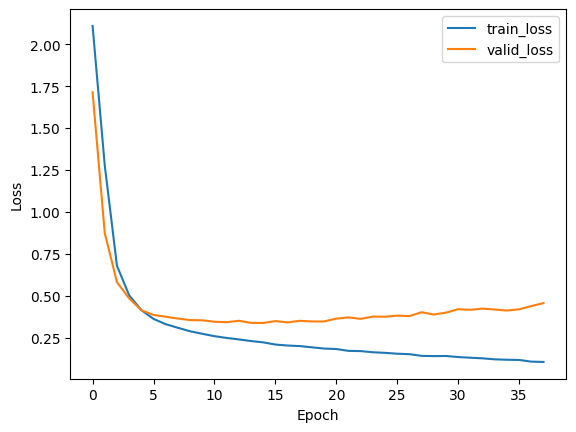

In [11]:
from matplotlib import pyplot as plt
### TODO : Please plot the rain/val loss curve ###


plt.plot(train_loss_epoch, label = 'train_loss')
plt.plot(val_loss_epoch, label = 'valid_loss')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.legend()
plt.show()
###########################################################

## Downloading ".onnx file" , and using  Netron to visualize the model


Save the model in .onnx format


In [12]:
# Some standard imports
import io
import torch.utils.model_zoo as model_zoo
import torch.onnx

trained_net = Our_MobileNetV3().cuda()

input_shape = torch.randn(1,1,28,28).cuda()
trained_net_weight = torch.load("N26122246_minist_best.ckpt")
trained_net.load_state_dict(trained_net_weight,strict=False)
trained_net.eval()

### TODO : export your model in .onnx format ###
torch.onnx.export( trained_net,
                  input_shape,
                  "N26122246_fashion_mnist.onnx",
                  opset_version=10,
                  do_constant_folding=True,
                  input_names = ['input'],
                  output_names = ['output'],
                  dynamic_axes={'input' : {0 : 'batch_size'},    # variable length axes
                                'output' : {0 : 'batch_size'}})



https://netron.app/